In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
filePath = '/Users/Prashanth/Downloads/DSProject/final_dataset.csv'       ### Local path of the csv file 
data = pd.read_csv(filePath)           ### Read the csv file
display(data.head())                   ### Preview the data
data.keys()                            ### Preview the columns available

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,0,2019-08-16,Ath Bilbao,Barcelona,1,0,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,9.0
1,1,2019-08-17,Celta,Real Madrid,1,3,NH,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,16.0
2,2,2019-08-17,Valencia,Sociedad,1,1,NH,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0
3,3,2019-08-17,Mallorca,Eibar,2,1,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,5.0
4,4,2019-08-17,Leganes,Osasuna,0,1,NH,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,8.0


Index(['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
       'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP',
       'AwayTeamLP', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts',
       'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3',
       'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3',
       'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP'],
      dtype='object')

##### ***DESCRIPTION OF THE DATA***
###### ***Full Time Result*** (H=Home Win, D=Draw, A=Away Win)
###### ***HTGD*** - Home team goal difference
###### ***ATGD*** - away team goal difference
###### ***HTP*** - Home team points
###### ***ATP*** - Away team points
###### ***DiffFormPts*** -  Diff in points
###### ***DiffLP*** - Differnece in last years prediction
###### ***Input*** - 12 other features (fouls, shots, goals, misses,corners, red card, yellow cards)
###### ***Output*** - Full Time Result (H=Home Win, D=Draw, A=Away Win) 

<AxesSubplot:>

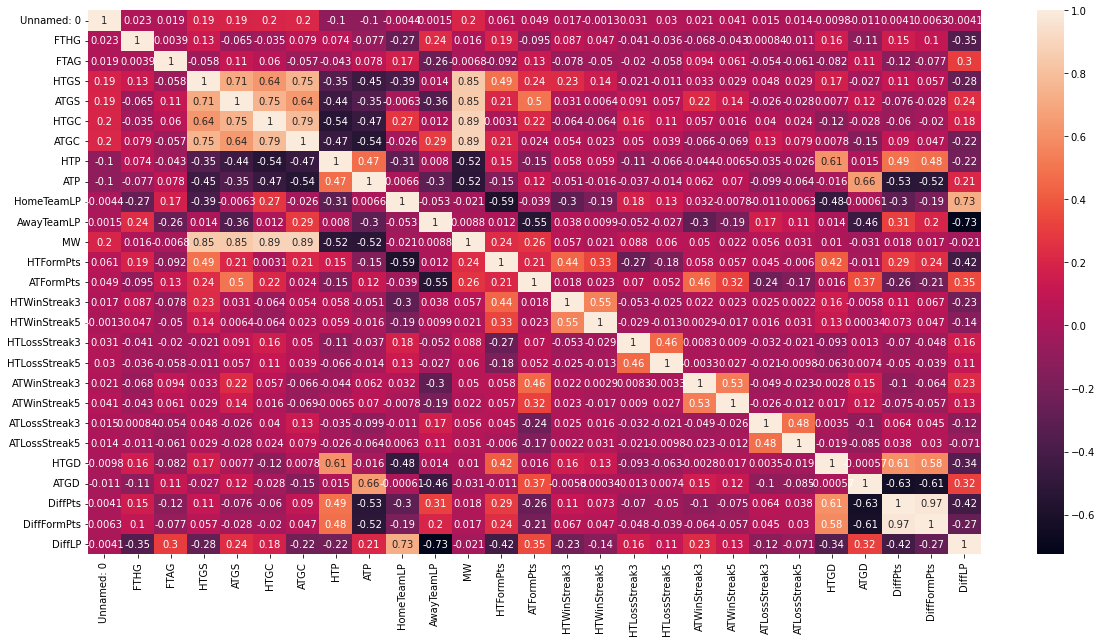

In [3]:
# Creating a correlation matrix for the given data
numericData = data.select_dtypes( include = ['float64', 'int64'] )
plt.figure( figsize=(20,10) ) 
sns.heatmap( numericData.corr(), annot = True )

In [4]:
# Removing the unnecessary columns 
cleanData = data.copy().drop( columns =['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 
        'FTAG', 'HTGS', 'ATGS', 'HTGC', 'ATGC',
       'HM4', 'HM5','AM4', 'AM5', 'MW', 'HTFormPtsStr',
       'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3',
       'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 
       'ATWinStreak3','ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'DiffPts'] )
cleanData.keys()
cleanData.head(5)

,Unnamed: 0,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HomeTeamLP,AwayTeamLP,HTGD,ATGD,DiffFormPts,DiffLP
0,0,H,0.0,0.0,M,M,M,M,M,M,11.0,2.0,0.0,0.0,0.0,9.0
1,1,NH,0.0,0.0,M,M,M,M,M,M,17.0,1.0,0.0,0.0,0.0,16.0
2,2,NH,0.0,0.0,M,M,M,M,M,M,9.0,6.0,0.0,0.0,0.0,3.0
3,3,H,0.0,0.0,M,M,M,M,M,M,19.0,14.0,0.0,0.0,0.0,5.0
4,4,NH,0.0,0.0,M,M,M,M,M,M,18.0,10.0,0.0,0.0,0.0,8.0


In [5]:
from sklearn.impute import SimpleImputer

# Check for missing values in the dataset and separate the numeric and categorical columns from those
print("Missing values per column before imputation:\n", cleanData.isnull().sum())
numeric_columns = cleanData.select_dtypes(include=['number']).columns
categorical_columns = cleanData.select_dtypes(include=['object', 'category']).columns

# Impute numeric columns using 'mean' and categorical columns using the 'most frequent value'
imputer_mean = SimpleImputer(strategy='mean')
cleanData[numeric_columns] = imputer_mean.fit_transform(cleanData[numeric_columns])
imputer_mode = SimpleImputer(strategy='most_frequent')
cleanData[categorical_columns] = imputer_mode.fit_transform(cleanData[categorical_columns])

# Confirm for missing values after imputation
print("Missing values per column after imputation:\n", cleanData.isnull().sum())

Missing values per column before imputation:
 Unnamed: 0     0
FTR            0
HTP            0
ATP            0
HM1            0
HM2            0
HM3            0
AM1            0
AM2            0
AM3            0
HomeTeamLP     0
AwayTeamLP     0
HTGD           0
ATGD           0
DiffFormPts    0
DiffLP         0
dtype: int64
Missing values per column after imputation:
 Unnamed: 0     0
FTR            0
HTP            0
ATP            0
HM1            0
HM2            0
HM3            0
AM1            0
AM2            0
AM3            0
HomeTeamLP     0
AwayTeamLP     0
HTGD           0
ATGD           0
DiffFormPts    0
DiffLP         0
dtype: int64


In [6]:
# Check the unique values in the 'FTR' column and their 'Counts'
print("Distinctive values in 'FTR' column and their 'Counts':\n", cleanData['FTR'].value_counts())

# Calculate the number of matches resulting in a home win and not a home win
homewinsNum = len(cleanData[cleanData.FTR == 'H'])
notHomeWinsNum = len(cleanData[cleanData.FTR == 'NH'])
print("\nMatches won by home team: {}".format(homewinsNum))
print("Matches not won by home team (NH): {}".format(notHomeWinsNum))

Distinctive values in 'FTR' column and their 'Counts':
 NH    1054
H      846
Name: FTR, dtype: int64

Matches won by home team: 846
Matches not won by home team (NH): 1054


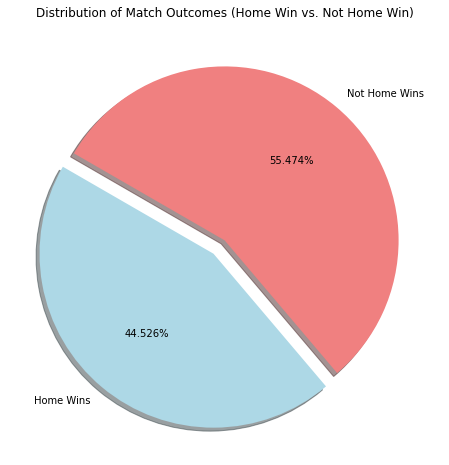

In [7]:
# Piechart plotting for the above comparison
labels = ['Home Wins', 'Not Home Wins']
sizes = [homewinsNum, notHomeWinsNum]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # Explode the first slice (Home Wins)
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.3f%%', shadow=True, startangle=150)
plt.title('Distribution of Match Outcomes (Home Win vs. Not Home Win)')
plt.show()

array([[<AxesSubplot:xlabel='HTGD', ylabel='HTGD'>,
        <AxesSubplot:xlabel='ATGD', ylabel='HTGD'>,
        <AxesSubplot:xlabel='HTP', ylabel='HTGD'>,
        <AxesSubplot:xlabel='ATP', ylabel='HTGD'>,
        <AxesSubplot:xlabel='DiffFormPts', ylabel='HTGD'>],
       [<AxesSubplot:xlabel='HTGD', ylabel='ATGD'>,
        <AxesSubplot:xlabel='ATGD', ylabel='ATGD'>,
        <AxesSubplot:xlabel='HTP', ylabel='ATGD'>,
        <AxesSubplot:xlabel='ATP', ylabel='ATGD'>,
        <AxesSubplot:xlabel='DiffFormPts', ylabel='ATGD'>],
       [<AxesSubplot:xlabel='HTGD', ylabel='HTP'>,
        <AxesSubplot:xlabel='ATGD', ylabel='HTP'>,
        <AxesSubplot:xlabel='HTP', ylabel='HTP'>,
        <AxesSubplot:xlabel='ATP', ylabel='HTP'>,
        <AxesSubplot:xlabel='DiffFormPts', ylabel='HTP'>],
       [<AxesSubplot:xlabel='HTGD', ylabel='ATP'>,
        <AxesSubplot:xlabel='ATGD', ylabel='ATP'>,
        <AxesSubplot:xlabel='HTP', ylabel='ATP'>,
        <AxesSubplot:xlabel='ATP', ylabel='ATP'>,
     

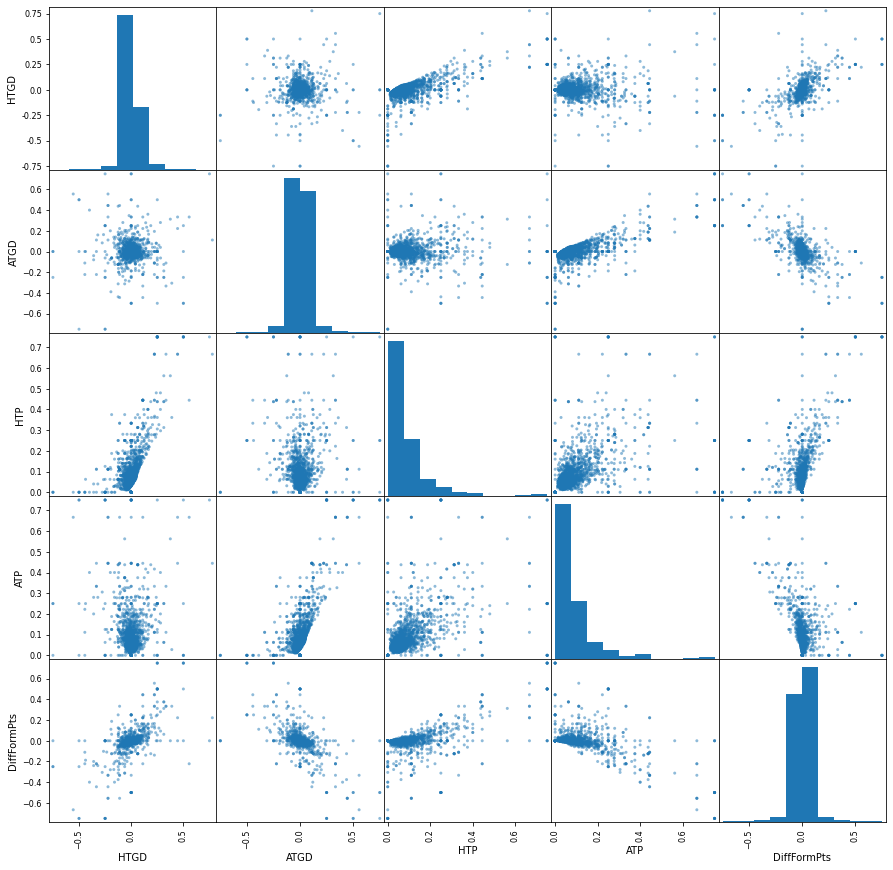

In [8]:
# Visualising distribution of data with scatter matrix
from pandas.plotting import scatter_matrix
scatter_matrix(cleanData[['HTGD','ATGD','HTP','ATP','DiffFormPts']], figsize=(15,15))

## PREPARING THE DATA

In [9]:
# Standardising the data.
from sklearn.preprocessing import scale
xAll = cleanData.drop(['FTR'],axis=1)
yAll = cleanData['FTR']
cols = [['HTGD','ATGD','HTP','ATP']]
for col in cols:
    xAll[col] = scale(xAll[col])
    
def preprocess_features(X):
    ''' Preprocesses the football data and converts 
    catagorical variables into dummy 
    variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)
    
    # Investigate each feature column for the data
    for col, col_data in X.items():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
        output = output.join(col_data)
    return output

# Lets take last 3 wins for both sides
xAll.HM1 = xAll.HM1.astype('str')
xAll.HM2 = xAll.HM2.astype('str')
xAll.HM3 = xAll.HM3.astype('str')
xAll.AM1 = xAll.AM1.astype('str')
xAll.AM2 = xAll.AM2.astype('str')
xAll.AM3 = xAll.AM3.astype('str')

xAll = preprocess_features(xAll)
print ("Processed feature columns ({} total features):\n{}".format(len(xAll.columns), list(xAll.columns)))
    

Processed feature columns (33 total features):
['Unnamed: 0', 'HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HomeTeamLP', 'AwayTeamLP', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [10]:
# Show the feature information by printing the first five rows
print("\nFeature values:")
display(xAll.head())


Feature values:


,Unnamed: 0,HTP,ATP,HM1_D,HM1_L,HM1_M,HM1_W,HM2_D,HM2_L,HM2_M,...,AM3_D,AM3_L,AM3_M,AM3_W,HomeTeamLP,AwayTeamLP,HTGD,ATGD,DiffFormPts,DiffLP
0,0.0,-0.878433,-0.867514,0,0,1,0,0,0,1,...,0,0,1,0,11.0,2.0,0.003933,-0.022599,0.0,9.0
1,1.0,-0.878433,-0.867514,0,0,1,0,0,0,1,...,0,0,1,0,17.0,1.0,0.003933,-0.022599,0.0,16.0
2,2.0,-0.878433,-0.867514,0,0,1,0,0,0,1,...,0,0,1,0,9.0,6.0,0.003933,-0.022599,0.0,3.0
3,3.0,-0.878433,-0.867514,0,0,1,0,0,0,1,...,0,0,1,0,19.0,14.0,0.003933,-0.022599,0.0,5.0
4,4.0,-0.878433,-0.867514,0,0,1,0,0,0,1,...,0,0,1,0,18.0,10.0,0.003933,-0.022599,0.0,8.0


# SPLITING THE DATASET

In [11]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report,mean_squared_error
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

# APPLYING THE LOGISTIC REGRESSION

In [12]:
# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(xAll, yAll, test_size = 0.3,
                                                    random_state = 2, stratify = yAll)
# Fitting Logistic Regression to the Training set
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, Y_pred)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[152 102]
 [ 78 238]]


<AxesSubplot:>

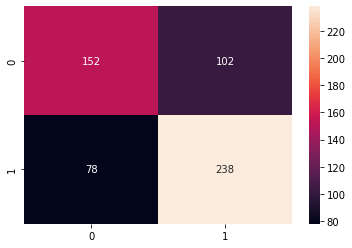

In [13]:
print(cm)
sns.heatmap(cm, annot=True,fmt='d')

In [14]:
# Evaluate performance
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           H       0.66      0.60      0.63       254
          NH       0.70      0.75      0.73       316

    accuracy                           0.68       570
   macro avg       0.68      0.68      0.68       570
weighted avg       0.68      0.68      0.68       570



In [15]:
# Calculating the accuracy
report1 = classification_report(y_test, Y_pred, output_dict=True)
accuracy0, precision0, f1_score0, recall0= report1['accuracy'], report1['H']['precision'], report1['H']['f1-score'], report1['H']['recall']
print(f"Accuracy: {accuracy0:.4f}")

Accuracy: 0.6842


# ADJUSTING DECISION THRESHOLD (Logistic Regression)

[[152 102]
 [ 78 238]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


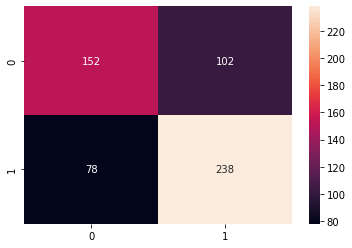

In [16]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable for training and testing data
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit the model with encoded y_train
model = LogisticRegression()
model.fit(X_train, y_train_encoded)

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Adjust threshold and get predictions
threshold = 0.5
y_pred_encoded = (y_prob >= threshold).astype(int)

cm1 = confusion_matrix(y_test_encoded, y_pred_encoded)
sns.heatmap(cm1, annot=True,fmt='d')
print(cm1)


In [17]:
# Evaluate performance
print(classification_report(y_test_encoded, y_pred_encoded))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       254
           1       0.70      0.75      0.73       316

    accuracy                           0.68       570
   macro avg       0.68      0.68      0.68       570
weighted avg       0.68      0.68      0.68       570



In [18]:
# Calculate accuracy
accuracy_1 = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy_1:.4f}")

Accuracy: 0.6842


# POLYNOMIAL FEATURES

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix with polynomial features:
 [[151 103]
 [ 78 238]]


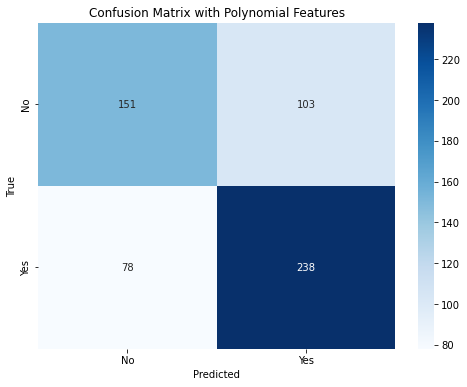

In [19]:
# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(xAll)

# Split and train with polynomial features
X_train, X_test, y_train, y_test = train_test_split(X_poly, yAll, test_size=0.3, random_state=2, stratify=yAll)
classifier.fit(X_train, y_train)
Y_pred_poly = classifier.predict(X_test)

# Evaluate
cm_poly = confusion_matrix(y_test, Y_pred_poly)
print("Confusion Matrix with polynomial features:\n", cm_poly)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_poly, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Polynomial Features')
plt.show()

In [20]:
# Evaluate performance
print(classification_report(y_test, Y_pred_poly))

              precision    recall  f1-score   support

           H       0.66      0.59      0.63       254
          NH       0.70      0.75      0.72       316

    accuracy                           0.68       570
   macro avg       0.68      0.67      0.67       570
weighted avg       0.68      0.68      0.68       570



In [21]:
# Calculate accuracy
accuracy_2= accuracy_score(y_test, Y_pred_poly)
print(f"Accuracy: {accuracy_2:.4f}")

Accuracy: 0.6825


# APPLYING THE RANDOM FOREST

In [22]:
classifier = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=700, n_jobs=-1,
                       oob_score=True, random_state=1)

In [23]:
y_train

96      NH
1540    NH
289      H
124      H
504      H
        ..
1147    NH
1298    NH
273      H
53      NH
1891    NH
Name: FTR, Length: 1330, dtype: object

In [24]:
#predicting result
Y_pred1 = classifier.predict(X_test)

In [25]:
# Making the Confusion Matrix
cm2 = confusion_matrix(y_test, Y_pred1)

[[153 101]
 [ 74 242]]


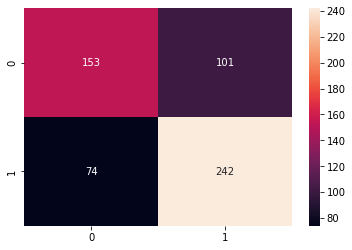

In [26]:
sns.heatmap(cm2, annot=True, fmt='d')
print(cm2)

In [27]:
# Generate the classification report
report3 = classification_report(y_test, Y_pred1, output_dict=True)
print(classification_report(y_test, Y_pred1))
# Extract accuracy from the report
accuracy_3, precision_3, f1_score_3, recall_3= report3['accuracy'], report3['H']['precision'], report3['H']['f1-score'], report3['H']['recall']

print(f"Accuracy: {accuracy_3:.4f}")


              precision    recall  f1-score   support

           H       0.67      0.60      0.64       254
          NH       0.71      0.77      0.73       316

    accuracy                           0.69       570
   macro avg       0.69      0.68      0.69       570
weighted avg       0.69      0.69      0.69       570

Accuracy: 0.6930


In [28]:
cleanData.keys()

Index(['Unnamed: 0', 'FTR', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'AM1', 'AM2',
       'AM3', 'HomeTeamLP', 'AwayTeamLP', 'HTGD', 'ATGD', 'DiffFormPts',
       'DiffLP'],
      dtype='object')

# ADJUSTING DECISION THRESHOLD (Random Forest)

In [29]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert string labels to integer labels
y_train_int = label_encoder.fit_transform(y_train)
y_test_int = label_encoder.transform(y_test)

# Initialize and fit the RandomForestClassifier with class weight adjustment
rf_weighted_manual = RandomForestClassifier(
    criterion='gini',
    n_estimators=700,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight={0: 1, 0: 1},  # Example weights, adjust as necessary
    random_state=1,
    n_jobs=-1
)
rf_weighted_manual.fit(X_train, y_train_int)

# Predict probabilities
y_prob = rf_weighted_manual.predict_proba(X_test)[:, 1]

# Adjust threshold
threshold = 0.5
Y_pred_adjusted = (y_prob >= threshold).astype(int)

[[153 101]
 [ 74 242]]


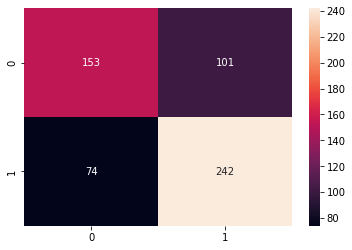

In [30]:
cm3 = confusion_matrix(y_test_int, Y_pred_adjusted)
sns.heatmap(cm3, annot=True, fmt='d')
print(cm3)

In [31]:
# Evaluate performance
print(classification_report(y_test_int, Y_pred_adjusted, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

           H       0.67      0.60      0.64       254
          NH       0.71      0.77      0.73       316

    accuracy                           0.69       570
   macro avg       0.69      0.68      0.69       570
weighted avg       0.69      0.69      0.69       570



In [32]:
# Calculate and print accuracy
accuracy_4 = accuracy_score(y_test_int, Y_pred_adjusted)
print(f"Accuracy: {accuracy_4:.4f}")

Accuracy: 0.6930


# APPLYING THE XGBOOST

In [33]:
from xgboost import XGBClassifier

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = label_encoder.fit_transform(y_train)

# Fitting XGBoost to the Training set
classifier = XGBClassifier(seed=82)
classifier.fit(X_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
# Predicting the Test set results
Y_pred2 = classifier.predict(X_test)

In [35]:
# Encode y_test to match the format of Y_pred
y_test_encoded1 = label_encoder.transform(y_test)

# Now compute the confusion matrix
cm4 = confusion_matrix(y_test_encoded1, Y_pred2)


[[155  99]
 [ 90 226]]


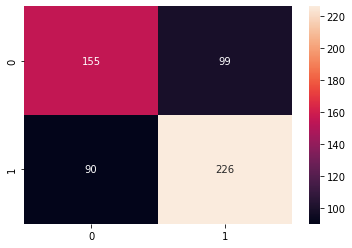

In [36]:
sns.heatmap(cm4, annot=True,fmt='d')
print(cm4)

In [37]:
# Decode predictions back to original labels
Y_pred_decoded = label_encoder.inverse_transform(Y_pred2)

# Print classification report
print(classification_report(y_test, Y_pred_decoded))


              precision    recall  f1-score   support

           H       0.63      0.61      0.62       254
          NH       0.70      0.72      0.71       316

    accuracy                           0.67       570
   macro avg       0.66      0.66      0.66       570
weighted avg       0.67      0.67      0.67       570



In [38]:
# Generate the classification report
report3 = classification_report(y_test, Y_pred_decoded, output_dict=True)

# Extract accuracy from the report
accuracy_5, precision_5, f1_score_5, recall_5= report3['accuracy'], report3['H']['precision'], report3['H']['f1-score'], report3['H']['recall']

print(f"Accuracy: {accuracy_5:.4f}")


Accuracy: 0.6684


# TUNING THE PARAMETER OF XGBOOST

In [39]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# Parameters to tune
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [40],
    'max_depth': [3],
    'min_child_weight': [3],
    'gamma': [0.4],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [1],
    'reg_alpha': [1e-5]
}

# Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# Make an f1 scoring function using 'make_scorer'
f1_scorer = make_scorer(f1_score, pos_label=1)  # Change pos_label to 1

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, scoring=f1_scorer, param_grid=parameters, cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train_encoded)

# Get the best estimator
clf = grid_obj.best_estimator_
print(clf)

# Define predict_labels function
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score and accuracy. '''
    y_pred = clf.predict(features)
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred))

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train_encoded)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1, acc))

f1, acc = predict_labels(clf, X_test, y_test_encoded)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1, acc))



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
F1 score and accuracy score for training set: 0.8026 , 0.7744.
F1 score and accuracy score for test set: 0.7234 , 0.6807.


[[155  99]
 [ 90 226]]


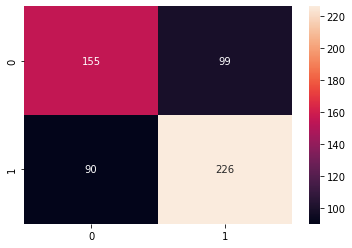

In [45]:
cm5 = confusion_matrix(y_test, Y_pred_decoded)
sns.heatmap(cm5, annot=True,fmt='d')
print(cm5)

In [46]:
print(classification_report(y_test, Y_pred_decoded))

              precision    recall  f1-score   support

           H       0.63      0.61      0.62       254
          NH       0.70      0.72      0.71       316

    accuracy                           0.67       570
   macro avg       0.66      0.66      0.66       570
weighted avg       0.67      0.67      0.67       570



In [47]:
# Generate the classification report
report = classification_report(y_test, Y_pred_decoded, output_dict=True)

# Extract accuracy from the report
accuracy_6= report['accuracy']

print(f"Accuracy: {accuracy_6:.4f}")


Accuracy: 0.6684


# COMPARISON OF MODEL ACCURACY

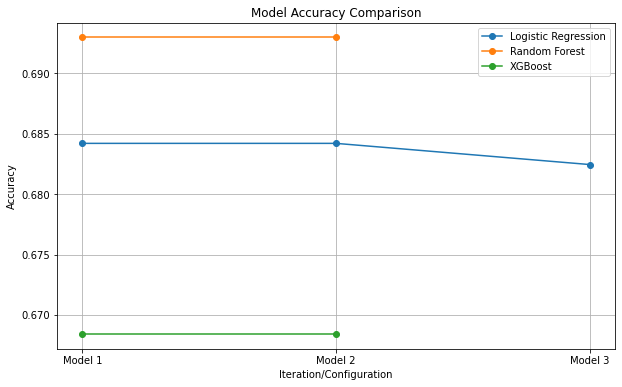

In [43]:
# Example accuracies for different models 
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = {
    'Logistic Regression': [accuracy0, accuracy_1, accuracy_2],  
    'Random Forest': [accuracy_3, accuracy_4],                  
    'XGBoost': [accuracy_5, accuracy_6],       
}

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each model's accuracy as a line plot
for i, model in enumerate(models):
    x = np.arange(len(accuracies[model]))  # X-axis values (iterations or configurations)
    plt.plot(x, accuracies[model], marker='o', label=model)  

# Add labels, title, and legend
plt.xlabel('Iteration/Configuration')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(np.arange(len(accuracies['Logistic Regression'])), [f'Model {i+1}' for i in np.arange(len(accuracies['Logistic Regression']))])  
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


# COMPARISON OF [HOME TEAM] MODEL ACCURACY, PRECISION, RECALL, F1-SCORE 

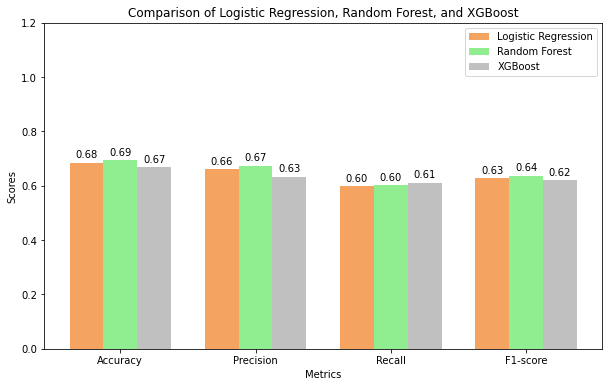

In [63]:
# Define the metrics and their corresponding values for each model
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']


# X-axis locations for the groups
x = np.arange(len(metrics_names))

# Width of the bars
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Logistic Regression
logistic_bars = ax.bar(x - width, [accuracy0, precision0, recall0, f1_score0], width, label='Logistic Regression', color= 'sandybrown')

# Bars for Random Forest
random_forest_bars = ax.bar(x, [accuracy_3, precision_3, recall_3, f1_score_3], width, label='Random Forest', color='lightgreen')

# Bars for XGBoost
xgboost_bars = ax.bar(x + width, [accuracy_5, precision_5, recall_5, f1_score_5], width, label='XGBoost', color='silver')

# Adding labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Logistic Regression, Random Forest, and XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim([0, 1.2])  # Since metrics are between 0 and 1
ax.legend()

# Adding value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(logistic_bars)
add_labels(random_forest_bars)
add_labels(xgboost_bars)

# Show plot
plt.show()